In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import os
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [2]:
columns = ['sno', 'movie', 'genre', 'desc']
df = pd.read_csv('/content/train_data.txt', sep=':::', names=columns, engine='python')
df_sol = pd.read_csv('/content/test_data_solution.txt', sep=':::', names=columns, engine='python')

columns_1 = ['sno', 'movie', 'desc']
df_test = pd.read_csv('/content/test_data.txt', sep=':::', names=columns_1, engine='python')

##EDA

In [3]:
df.head()

,sno,movie,genre,desc
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
df.shape

(54214, 4)

In [5]:
'''# creating genre columns
genres_dummies = df['genre'].str.get_dummies(sep=',')
df = pd.concat([df, genres_dummies], axis=1)

df.drop('genre', axis=1, inplace=True)
'''

"# creating genre columns\ngenres_dummies = df['genre'].str.get_dummies(sep=',')\ndf = pd.concat([df, genres_dummies], axis=1)\n\ndf.drop('genre', axis=1, inplace=True)\n"

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sno     54214 non-null  int64 
 1   movie   54214 non-null  object
 2   genre   54214 non-null  object
 3   desc    54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [7]:
df.describe()

,sno
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


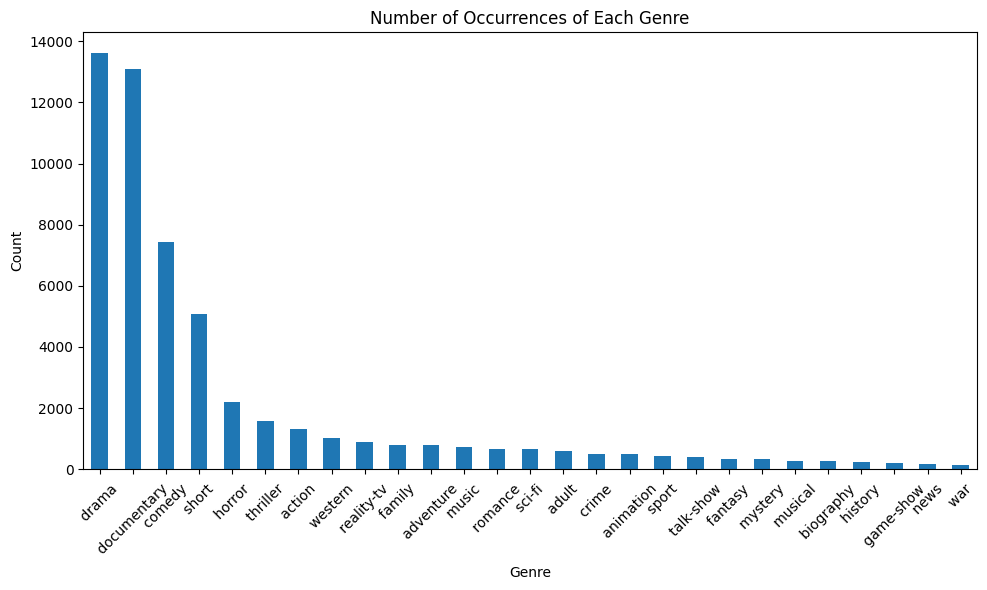

In [8]:
genre_counts = df['genre'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Number of Occurrences of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


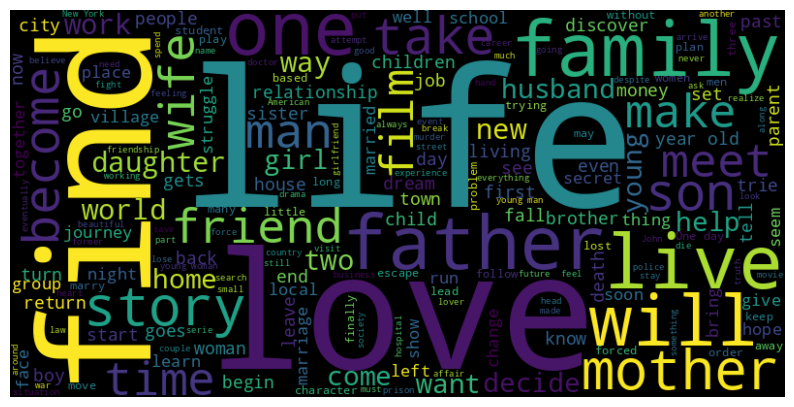

In [9]:
drama_desc = df[df['genre'] == ' drama ']['desc'].tolist()
# Joining all the drama desc into a single string
drama_text = ' '.join(drama_desc)
# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(drama_text)
# Plotting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [10]:
#Removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on desc column
df['desc']=df['desc'].apply(remove_special_characters)
df_test['desc']=df_test['desc'].apply(remove_special_characters)
df_sol['desc']=df_sol['desc'].apply(remove_special_characters)


In [11]:
nltk.download('stopwords')
nltk.download('punkt')
#Setting English stopwords
stopwords_en = set(stopwords.words('english'))

# function to remove stopwords from text
def remove_stopwords(text):
    words = word_tokenize(text)  # Tokenize text into words
    filtered_words = [word for word in words if word.lower() not in stopwords_en]  # Remove stopwords
    return ' '.join(filtered_words)  # Join filtered words back into a string

df['desc'] = df['desc'].apply(remove_stopwords)
df_test['desc'] = df_test['desc'].apply(remove_stopwords)
df_sol['desc'] = df_sol['desc'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Modelling

In [12]:
#TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(df['desc'])
X_test = tfidf_vectorizer.transform(df_test['desc'])

In [13]:
# Splitting the data
X = X_train
y = df['genre']

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# SVC classifier
classifier = SVC(kernel='linear', random_state=42)
classifier.fit(X_train, y_train)

# Making predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluating the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.5989117402932768


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.55      0.32      0.40       263
       adult        0.80      0.36      0.49       112
   adventure        0.50      0.21      0.29       139
   animation        0.56      0.10      0.16       104
   biography        0.00      0.00      0.00        61
      comedy        0.54      0.61      0.57      1443
       crime        0.25      0.02      0.03       107
 documentary        0.68      0.85      0.75      2659
       drama        0.55      0.79      0.65      2697
      family        0.52      0.11      0.19       150
     fantasy        0.67      0.03      0.05        74
   game-show        0.91      0.53      0.67        40
     history        0.00      0.00      0.00        45
      horror        0.69      0.64      0.66       431
       music        0.67      0.49      0.56       144
     musical        0.33      0.02      0.04        50
     mystery        1.00      0.02      0.04        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
X_test_predictions = classifier.predict(X_test)
df_test['Predicted_Genre'] = X_test_predictions

In [16]:
# Comparing predicted genres with actual labels
accuracy = (df_test["Predicted_Genre"] == df_sol["genre"]).mean()

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.5977675276752767
